In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import *
import random

# L'algorithme du recuit simulé

L'algorithme du recuit simulé permet de résoudre des problèmes d'optimisation non convexe, pour lesquels la méthode de descente du gradient n'est pas appropriée. On s'intéresse ici à une application au problème du voyageur de commerce (section 6.4 dans le poly).

## 1) Données numériques
On souhaite calculer le **plus court chemin cyclique** passant par toutes les capitales des états fédéraux américains (Hawaii et Alaska exclus). Ce problème provient de la collection d'exemples [TSPLIB](http://elib.zib.de/pub/mp-testdata/tsp/tsplib/tsplib.html). Les données dont on dispose sont les cordonnées géographiques des villes, regroupées dans une matrice `uscapitals_list` :

In [2]:
uscapitals_list = np.genfromtxt("uscapitals.csv", delimiter=",")

La i-ème ligne de la matrice `uscapitals_list` est le couple de coordonnées de la i-ème ville. Par exemple :

In [3]:
print(uscapitals_list[3])

[401. 841.]


Dans l'exemple que nous considérons ici, le parcours optimal est connu et stocké dans la variable `uscapitals_opt` :

In [4]:
uscapitals_opt = np.genfromtxt("uscapitals_opt.csv", delimiter=",").astype(np.int)-1
print(uscapitals_opt)

[ 0  7 37 30 43 17  6 27  5 36 18 26 16 42 29 35 45 32 19 46 20 31 38 47
  4 41 23  9 44 34  3 25  1 28 33 40 15 21  2 22 13 24 12 10 11 14 39  8]


C:\Users\thoma\AppData\Local\Temp/ipykernel_7664/1227525740.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  uscapitals_opt = np.genfromtxt("uscapitals_opt.csv", delimiter=",").astype(np.int)-1


Pour calculer la distance (en milles) entre les villes à partir de leurs cordonnées, on utilise la distance euclidienne classique :

In [5]:
def euclidian_dist(citya, cityb):
    return np.linalg.norm(cityb-citya)

In [6]:
uscapitals_distances = np.zeros((len(uscapitals_list),
                                 len(uscapitals_list)))
for i in range(len(uscapitals_list)):
    for j in range(len(uscapitals_list)):
        uscapitals_distances[i,j] = euclidian_dist(uscapitals_list[i], uscapitals_list[j])

In [7]:
cities = uscapitals_list
optimal = uscapitals_opt
distances = uscapitals_distances

## 2) L'algorithme
**Objectif à minimiser** Le coût $V$ d'un parcours est la somme des distances entres villes consécutives. On identifie un parcours avec une permutation $\sigma$ de l'ensemble $\{0,2,..,15\}$, que l'on représente par une liste. $\sigma(k)$ est donc la k-ème ville que l'on visite en suivant le parcours $\sigma$. On a donc :
$$
V(\sigma) = \sum_{i=1}^{n-1} d(\sigma(i), \sigma(i+1)) + d(\sigma(n), \sigma(1)) 
$$

**TODO** : La fonction `V` le tableau de l'ordre des villes `tour` et la matrice `distances`des distances entre villes, et retourne un nombre réel `c`.

In [54]:
def V(tour, distances):
    c = 0
    for i in range (len(tour)-1):#On itère pour calculer les distances entre les viles i et i+1 pour i allant de 1 à n-1
        c+=distances[tour[i],tour[i+1]]
    c+=distances[tour[-1],tour[0]] #On rajoute la dernière distance entre la ville n et 1 pour revenir à notre point de départ
    return c

**Algorithme du recuit simulé :** À chaque itération, l'algorithme propose un nouveau parcours, obtenu en tirant au hasard deux nombres $i$ et $j$ et en invertissant les villes $\sigma(i)$ et $\sigma(j)$ dans l'état courant.

**TODO** : La fonction `proposition` prend un tableau d'ordre des villes et retourne un nouveau tableau permuté. Par exemple, `proposition([0,1,2,3,4])` pourrait produire `[1,0,2,3,4]`.

In [160]:
def proposition(tour):
    i_different_j=False #Booléen vérifiant que i est différent de j pour être sûr que l'on a bien une permutation
    prop=tour.copy()
    while (i_different_j==False):
        ##On tire au hasard deux entiers inférieurs à la longueur de la liste tour
        i=np.random.randint(0,len(tour))#
        j=np.random.randint(0,len(tour))
        if (i!=j):
            ##Si les entiers sont différents, on effectue la permutation et on change la valeur du booléen i_différent_j pour sortir de la boucle whi
            tmp=prop[i]
            prop[i]=prop[j]
            prop[j]=tmp
            i_different_j=True
    return prop
print("Exemple :", [0,1,2,3,4], "->", proposition([0,1,2,3,4]))

Exemple : [0, 1, 2, 3, 4] -> [2, 1, 0, 3, 4]


Le deuxième ingrédient est le schéma de température, qui régit la décroissance de la température au cours du temps. Plusieurs choix sont possibles. On utilise pour commencer une décroissance polynomiale :

In [12]:
def T(i):
    return 300*((i+1)**(-0.03))

**TODO** : Dans la fonction suivante, on implémente l'algorithme. Les arguments sont
- la matrice des distances entre villes `distances`
- le nombre d'itérations `N_iter`
- l'état initial `initial_tour`
- une fonction de proposition de changement `proposition`
- une fonction `T` pour le schéma de température


La fonction retourne 
- l'état final `tour` après `N_iter` étapes 
- l'état  `best` qui a la valeur minimale pour la fonction coût (`V`) parmi tous les états visités 
- la liste `costseq` des valeurs de la fonction coût à chaque étape de l'algorithme
- la liste `bestseq` des meilleures valeurs dans la fonction coût trouvées par l'algorithme

In [243]:
def recuit_simule(distances, N_iter, initial_tour, proposition, T):
    
    tour=initial_tour
    best=initial_tour

    costseq=[]
    bestseq=[V(tour,distances)]
    for i in range (N_iter):
        temperature=T(i)
        
        tour_plus_un=proposition(tour)
        if (np.array_equal(tour,tour_plus_un)):
            print(1)
        cout_tour=V(tour,distances)
        cout_tour_plus_un=V(tour_plus_un,distances)
        
        difference_cout=cout_tour_plus_un-cout_tour
        u_n_plus_un=np.random.uniform()
        
        if (difference_cout<0):
            
            costseq.append(cout_tour_plus_un)
            tour=tour_plus_un
            if (cout_tour_plus_un<bestseq[-1]):
                best=tour_plus_un
                bestseq.append(cout_tour_plus_un)
        else:
            if (u_n_plus_un<np.exp(-difference_cout/temperature)):
                tour=tour_plus_un
                costseq.append(cout_tour_plus_un)
                if (cout_tour_plus_un<bestseq[-1]):
                    best=tour_plus_un
                    bestseq.append(cout_tour_plus_un)
    return tour, best, costseq, bestseq

Une collection d'états initiaux possibles est stockée dans la liste `problem_initial_tours` : le $i$-ème élément est obtenu en appliquant $i$ transpositions aléatoires au parcours optimal.

In [172]:
problem_initial_tours = []
for i in range(10):
    problem_initial_tours.append(optimal.copy())
    for k in range(i):
        problem_initial_tours[i] = proposition(problem_initial_tours[i])

On peut à présent tester l'algorithme et visualiser la décroissance dans la fonction objectif :

In [244]:
N_iter = 10000
i = 8
initial_tour = problem_initial_tours[i]

tour, best, cseq, bseq = recuit_simule(distances, N_iter, initial_tour, proposition, T)

In [248]:
V(best,distances),cseq[-1]

(42153.72176652503, 44223.18721381464)

In [206]:
def plot_recuit(cseq, bseq, best, optimal, legend=True, label=""):
    p1 = plt.axhline(V(optimal, distances), label='Valeur optimale', c="black", ls="--")
    p2, = plt.plot(cseq, label='V(X_n) '+label)
    p3, = plt.plot(bseq, label='V(Best_n) '+label)
    if legend:
        plt.legend(fontsize=12)
        plt.ylabel("Fonction objectif", fontsize=12)
        plt.xlabel("Nombre d'itérations", fontsize=12)

La différence entre la meilleure valeur de la fonction coût trouvée par l'algorithme et la valeur optimale est 8630.013259089435


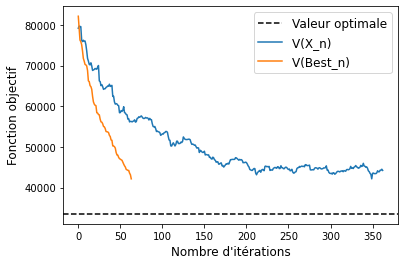

In [246]:
gap = V(best, distances) - V(optimal, distances)
print("La différence entre la meilleure valeur de la fonction coût trouvée par l'algorithme et la valeur optimale est", gap)
plot_recuit(cseq, bseq, best, optimal)

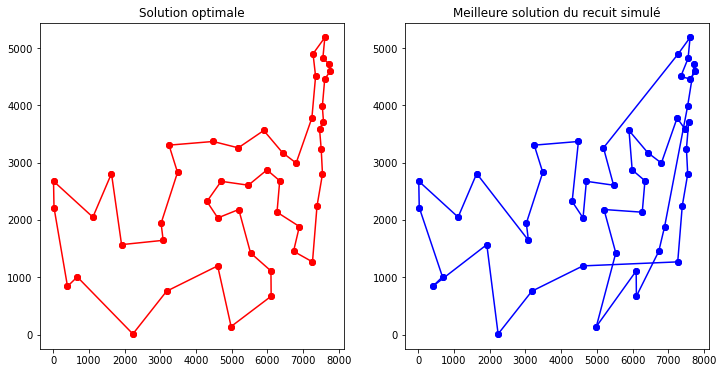

In [247]:
tt = optimal
total = len(cities)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.title('Solution optimale')
for i in range(total-1):
    plt.plot(np.array([cities[tt[i], 0], cities[tt[i+1], 0]]),
             np.array([cities[tt[i], 1], cities[tt[i+1], 1]]), '-ro')
plt.plot(np.array([cities[tt[total-1], 0], cities[tt[0], 0]]), np.array(
    [cities[tt[total-1], 1], cities[tt[0], 1]]), '-ro')

plt.subplot(1, 2, 2)
plt.title('Meilleure solution du recuit simulé')
for i in range(total-1):
    plt.plot(np.array([cities[best[i], 0], cities[best[i+1], 0]]),
             np.array([cities[best[i], 1], cities[best[i+1], 1]]), '-bo')

plt.plot(np.array([cities[best[total-1], 0], cities[best[0], 0]]), np.array(
    [cities[best[total-1], 1], cities[best[0], 1]]), '-bo')
plt.show()

## 3) Rôle de la proposition de changement

Dans la partie précédente, nous avons considéré la proposition de changement consistant à intervertir deux villes choisies au hasard. D'autres propositions sont possibles. Par exemple, au lieu d'intervertir deux villes, on peut en intervertir $k > 1$.

Une autre possibilité consiste à choisir deux villes $i,j$ au hasard et à les intervertir dans le parcours, ainsi que toutes les villes entre les deux.

**TODO** : implémenter la fonction `proposition_reverse`, qui prend un tableau d'ordre des villes et retourne un tableau permuté. Par exemple, `proposition_reverse([0, 1, 2, 3, 4, 5, 6])` pourrait produire `[0, 1, 2, 5, 4, 3, 6]`.

In [232]:
def proposition_reverse(tour):
    i_different_j=False #Booléen vérifiant que i est différent de j pour être sûr que l'on a bien une permutation
    prop=tour.copy()
    while (i_different_j==False):
        ##On tire au hasard deux entiers inférieurs à la longueur de la liste tour
        i=np.random.randint(0,len(tour))#
        j=np.random.randint(0,len(tour))
        if (i!=j):
            tmp=prop[i]
            prop[i]=prop[j]
            prop[j]=tmp
            prop[i+1:j]=np.random.permutation(prop[i+1:j])
            i_different_j=True
    return prop
print("Exemple :", [0,1,2,3,4,5,6], "->", proposition_reverse([0,1,2,3,4,5,6]))

Exemple : [0, 1, 2, 3, 4, 5, 6] -> [0, 1, 2, 6, 4, 5, 3]


La différence entre la meilleure valeur de la fonction coût trouvée par l'algorithme et la valeur optimale est 7753.44062462791


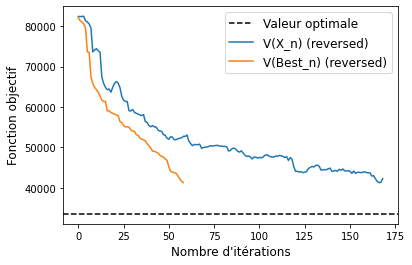

In [249]:
tour, best, cseq, bseq = recuit_simule(distances, 5000, initial_tour, proposition_reverse, T)
gap = V(best, distances) - V(optimal, distances)
print("La différence entre la meilleure valeur de la fonction coût trouvée par l'algorithme et la valeur optimale est", gap)
plot_recuit(cseq, bseq, best, optimal, label="(reversed)")

Enfin, on peut raffiner la règle `proposition_reverse` pour favoriser les interversions entre sommets proches dans l'itinéraire.
Par exemple, étant donné un sommet aléatoire $i$, on choisit le sommet $j$ avec probabilité $\frac C{|i-j|+1}$, avec $C$ une constante de normalisation.

**TODO** : adapter la fonction `proposition_reverse` pour ajouter une pondération dans le choix des sommets (on pourra utiliser la fonction `np.choice`).

In [259]:
def proposition_reverse_weighted(tour):
    prop=tour.copy()
    i=np.random.randint(0,len(tour))
    proba=[1/(abs(i-j)+1) for j in range(len(tour)) if j!=i]
    proba=np.insert(proba,i,0)
    C=1/np.sum(proba)
    j=np.random.choice(len(tour),p=np.multiply(C,proba))
    tmp=prop[i]
    prop[i]=prop[j]
    prop[j]=tmp
    prop[i+1:j]=np.random.permutation(prop[i+1:j])
    return prop
print("Exemple :", [0,1,2,3,4,5,6], "->", proposition_reverse_weighted([0,1,2,3,4,5,6]))

Exemple : [0, 1, 2, 3, 4, 5, 6] -> [0, 1, 3, 2, 4, 5, 6]


In [256]:
tour=[1,5,8,6,4,7]
i=2
proba=[1/(abs(i-j)+1) for j in range(len(tour)) if j!=i]
proba=np.insert(proba,i,0)
proba

array([0.33333333, 0.5       , 0.        , 0.5       , 0.33333333,
       0.25      ])

La différence entre la meilleure valeur de la fonction coût trouvée par l'algorithme et la valeur optimale est 14298.1357288855


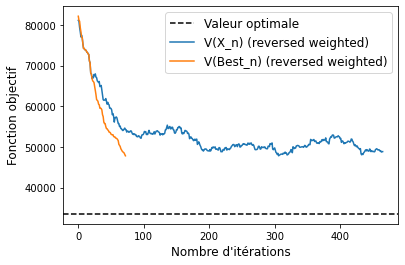

In [260]:
tour, best, cseq, bseq = recuit_simule(distances, 5000, initial_tour, proposition_reverse_weighted, T)
gap = V(best, distances) - V(optimal, distances)
print("La différence entre la meilleure valeur de la fonction coût trouvée par l'algorithme et la valeur optimale est", gap)
plot_recuit(cseq, bseq, best, optimal, label="(reversed weighted)")

Les méthodes `proposition_reverse` et `proposition_reverse_weighted` donnent des résultats proches à première vue. Pour les comparer, on effectue chaque simulation 50 fois et on compare les histogrammes des performances :

In [261]:
gaps_reverse = []
for _ in range(50):
    tour, best, cseq, bseq = recuit_simule(distances, 5000, initial_tour, proposition_reverse, T)
    gap = V(best, distances) - V(optimal, distances)
    gaps_reverse.append(gap)

In [262]:
gaps_reverse_weighted = []
for _ in range(50):
    tour, best, cseq, bseq = recuit_simule(distances, 5000, initial_tour, proposition_reverse_weighted, T)
    gap = V(best, distances) - V(optimal, distances)
    gaps_reverse_weighted.append(gap)

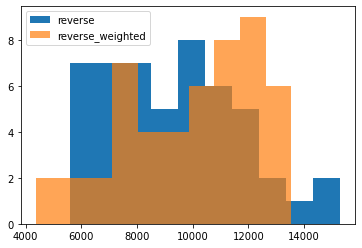

In [263]:
plt.hist(gaps_reverse ,label="reverse")
plt.hist(gaps_reverse_weighted, label="reverse_weighted", alpha=0.7)
plt.legend()
plt.show()

## 4) Schéma de température

On a utilisé jusqu'ici le schéma de température $T(i) = 300(i+1)^{-0.3}$ à décroissance polynomiale. D'autres choix sont bien sûr possibles.
On peut par exemple varier les constantes du schéma $T_{polynomial}(i) = a(i+1)^b$ :

In [ ]:
def T_polynomial(a, b):
    def T(i):
        return a*((i+1)**b)
    return T

On peut maintenant tester la performance de l'algorithme du recuit simulé sur plusieurs valeurs de $a$ et $b$ :

In [ ]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.3)
i = 1
for a in [100, 300, 1000]:
    for b in [-0.01, -0.03, -0.05]:
        T = T_polynomial(a, b)
        tour, best, cseq, bseq = recuit_simule(distances, 5000, initial_tour, proposition, T)
        gap = V(best, distances) - V(optimal, distances)
        plt.subplot(3,3,i)
        plt.title("a={}, b={}, gap={}".format(a,b,round(gap)))
        plot_recuit(cseq, bseq, best, optimal, legend=False)
        i += 1
plt.show()

A titre de comparaison, on peut également tester un schéma de température à décroissance exponentielle $T_{exponential}(i) = a*b^i$ (avec $0<b<1$).

In [ ]:
def T_exponential(a, b):
    # TODO
    return T

**TODO** : faire des tests similaires pour les températures exponentielles. $a$ est de l'ordre de $10^3$-$10^4$, et $b$ doit être proche de 1. Si on veut faire tourner le code pour $N_{iter} =5000$, il vaut mieux choisir $b$ entre $0.999$ et $1$ pour eviter des erreurs de compilation (overflow).

In [ ]:
# TODO

On peut aussi utiliser des schémas non décroissants : l'idée est alors d'alterner les phases de réchauffement et de refroidissement. On essaye ici $T_{oscillatory}(i) = a(i+1)^b(\cos((2\pi i)/c)^2+d)$.

In [ ]:
def T_oscillatory(a, b, c, d):
    def T(i):
        return a*((i+1)**b)*(np.cos(2*np.pi*i/c)**2 + d)
    return T

x = np.linspace(0,2000,200)
plt.plot(x, T_oscillatory(500,-0.3,1600,0.2)(x), label="T_oscillatory")
plt.plot(x, T_polynomial(300,-0.3)(x), label="T_polynomial")
plt.axhline(0, c="black")
plt.legend(fontsize=12)
plt.show()

**TODO** : observer le comportement du schéma de température oscillant et l'influence des paramètres du schéma sur le résultat.

## 5) Pour aller plus loin...

Vous pouvez tester l'algorithme sur des instances plus difficiles. Les données sont organisées comme celles du problème `us_capitals`.
- Le problème `gr96` consiste à calculer le plus court cycle reliant 96 villes en Afrique
- Le problème `tsp225` relie 225 villes générées automatiquement

Dans le jeux de données `gr96`, les villes sont données en coordonnées sphériques (latitude, longitude). Pour calculer les distances entre villes, on utilise la fonction `earth_dist`, définie ci-dessous à l'aide du module `geopy` ([disponible](https://pypi.org/project/geopy/) via `pip`) :

In [ ]:
from geopy import distance

def earth_dist(citya, cityb):
    return distance.distance(citya, cityb).miles

In [ ]:
gr96_list = np.genfromtxt("gr96.csv", delimiter=",")
gr96_opt = np.genfromtxt("gr96_opt.csv", delimiter=",").astype(np.int)-1
gr96_distances = np.array([[earth_dist(ca, cb) for ca in gr96_list] for cb in gr96_list])

In [ ]:
tsp225_list = np.genfromtxt("tsp225.csv", delimiter=",")
tsp225_opt = np.genfromtxt("tsp225_opt.csv", delimiter=",").astype(np.int)-1
tsp225_distances = np.array([[euclidian_dist(ca, cb) for ca in tsp225_list] for cb in tsp225_list])

In [ ]:
cities = gr96_list
optimal = gr96_opt
distances = gr96_distances

## 6) Conclusions
1. Que fait l'algorithme du recuit simulé ? Pour quels types de problèmes est-il pertinent ?

2. Quel est le rôle de la proposition de changement ? Comment la choisir ?

3. Quel est le rôle du schéma de température ? Comment le choisir ?